# Comparison of fluxes in pFBA solutions of iCH360 and iML1515 across growth conditions
In this notebook, we perform an pairwise flux comparisons between pFBA solutions obtained in iCH360 and iML1515 across a range of growth condtions

In [5]:
import cobra
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from cobra.flux_analysis import pfba
import os

In [6]:
# read models
iCH360=cobra.io.read_sbml_model('../../Model/iCH360/Escherichia_coli_iCH360.xml')
iML1515=cobra.io.read_sbml_model('../../Manuscript_Figures/data/metabolic_models/iML1515/iML1515.xml')

#Use a simplex solver, rather than an interior-point one, to make sure that zeros in the solution are returned as zeros, rather than small float within the solver tolerances
cobra.util.solver.choose_solver(iCH360,'gurobi')
cobra.util.solver.choose_solver(iML1515,'gurobi')

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-15


'gurobi'

In [7]:
if not os.path.exists('./out'):
    os.mkdir('./out')

carbon sources to be used for analysis

In [8]:
carbon_sources=['glc__D','fru','lac__D','ac','pyr' ,'glyc','rib__D','xyl__D','succ','fum','akg']
carbon_sources_names=['Glucose','Fructose','Lactate','Acetate','Pyruvate','Glycerol','Ribose','Xylose','Succinate','Fumarate','AKG']
carbon_source_id_name_map={cs:cs_name for cs,cs_name in zip(carbon_sources,carbon_sources_names)}
conditions=['aerobic','anaerobic']
iCH360_rxns=[r.id for r in iCH360.reactions]
iCH360_rxns.remove('Biomass')

Run pFBA for each condition and store results in a dictionary:

In [9]:
results={cs:{'aerobic':None,'anaerobic':None} for cs in carbon_sources}
for cs in carbon_sources:
    for condition in conditions:
        print(f'{cs}, {condition}...')
        results_df=pd.DataFrame(index=iCH360_rxns,
                                            columns=['iCH360','iML1515']
                                            )
        iCH360_is_optimal=False
        iML1515_is_optimal=False
        with iCH360 as m:
            m.reactions.EX_glc__D_e.lower_bound=0
            cur_exchange=f'EX_{cs}_e'
            m.reactions.get_by_id(cur_exchange).lower_bound=-10
            if condition=='anaerobic':
                m.reactions.EX_o2_e.lower_bound=0
            try:
                sol=pfba(m)
                if sol.status=='optimal':
                    print('iCH360: optimal')
                    iCH360_is_optimal=True
                    results_df['iCH360']=sol.fluxes[iCH360_rxns]
            except:
                print('iCH360',sol.status, 'Skipping')
        with iML1515 as m:
            m.reactions.EX_glc__D_e.lower_bound=0
            cur_exchange=f'EX_{cs}_e'
            m.reactions.get_by_id(cur_exchange).lower_bound=-10
            if condition=='anaerobic':
                m.reactions.EX_o2_e.lower_bound=0
            try:
                sol=pfba(m)
                if sol.status=='optimal':
                    print('iML1515: optimal')
                    iML1515_is_optimal=True
                    results_df['iML1515']=sol.fluxes[iCH360_rxns]
            except:
                print('iML1515',sol.status, 'Skipping')

        if iCH360_is_optimal and iML1515_is_optimal:
            results[cs][condition]=results_df
        else:
            results[cs][condition]=None

glc__D, aerobic...
iCH360: optimal
iML1515: optimal
glc__D, anaerobic...
iCH360: optimal
iML1515: optimal
fru, aerobic...
iCH360: optimal
iML1515: optimal
fru, anaerobic...
iCH360: optimal
iML1515: optimal
lac__D, aerobic...
iCH360: optimal
iML1515: optimal
lac__D, anaerobic...
iCH360 optimal Skipping
iML1515 optimal Skipping
ac, aerobic...
iCH360: optimal
iML1515: optimal
ac, anaerobic...
iCH360 optimal Skipping
iML1515 optimal Skipping
pyr, aerobic...
iCH360: optimal
iML1515: optimal
pyr, anaerobic...
iCH360: optimal
iML1515: optimal
glyc, aerobic...
iCH360: optimal
iML1515: optimal
glyc, anaerobic...
iCH360: optimal
iML1515: optimal
rib__D, aerobic...
iCH360: optimal
iML1515: optimal
rib__D, anaerobic...
iCH360: optimal
iML1515: optimal
xyl__D, aerobic...
iCH360: optimal
iML1515: optimal
xyl__D, anaerobic...
iCH360: optimal
iML1515: optimal
succ, aerobic...
iCH360: optimal
iML1515: optimal
succ, anaerobic...
iCH360 optimal Skipping
iML1515 optimal Skipping
fum, aerobic...
iCH360: op

# Plotting
Since metabolic fluxes can span order of magnitudes, relative differences between fluxes are more meaningfully computed in relative terms, rather than absolute ones (i.e. in log-scale, rather than linear one). However, FBA solutions involve zeros, which are problematic when computeing relative differences. For this analysis, we set zero fluxes to a small $\epsilon$.

Further, for clarity in the plots, we only include in the plot reactions whose absolute log10-fluxes differ between the models by more than <threshold_diff> (in both direction)


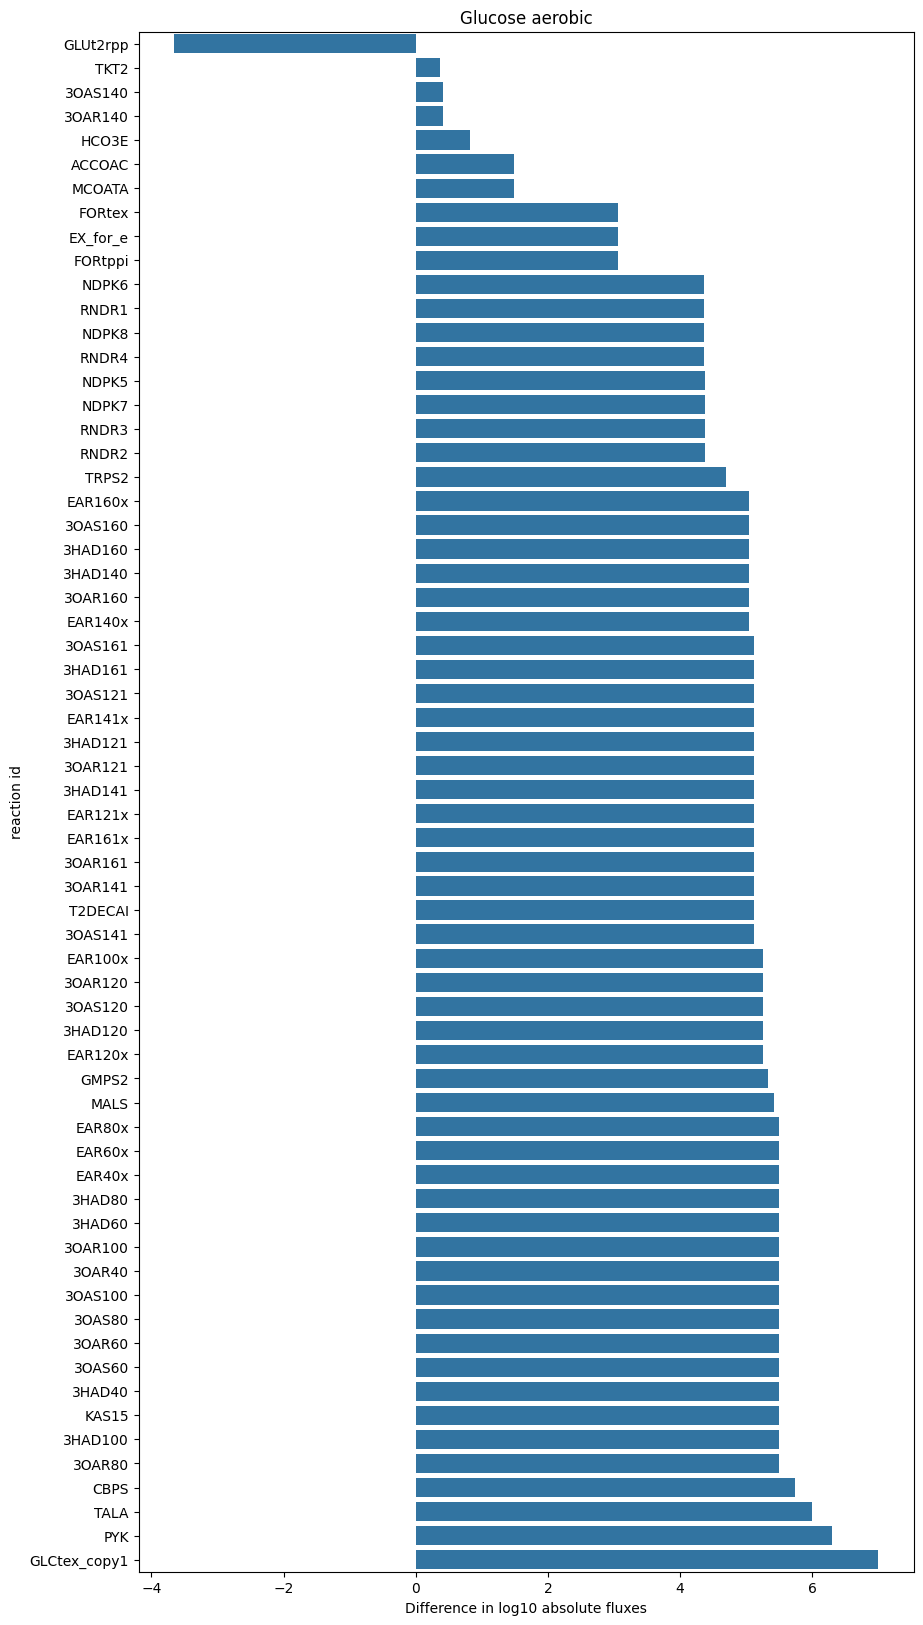

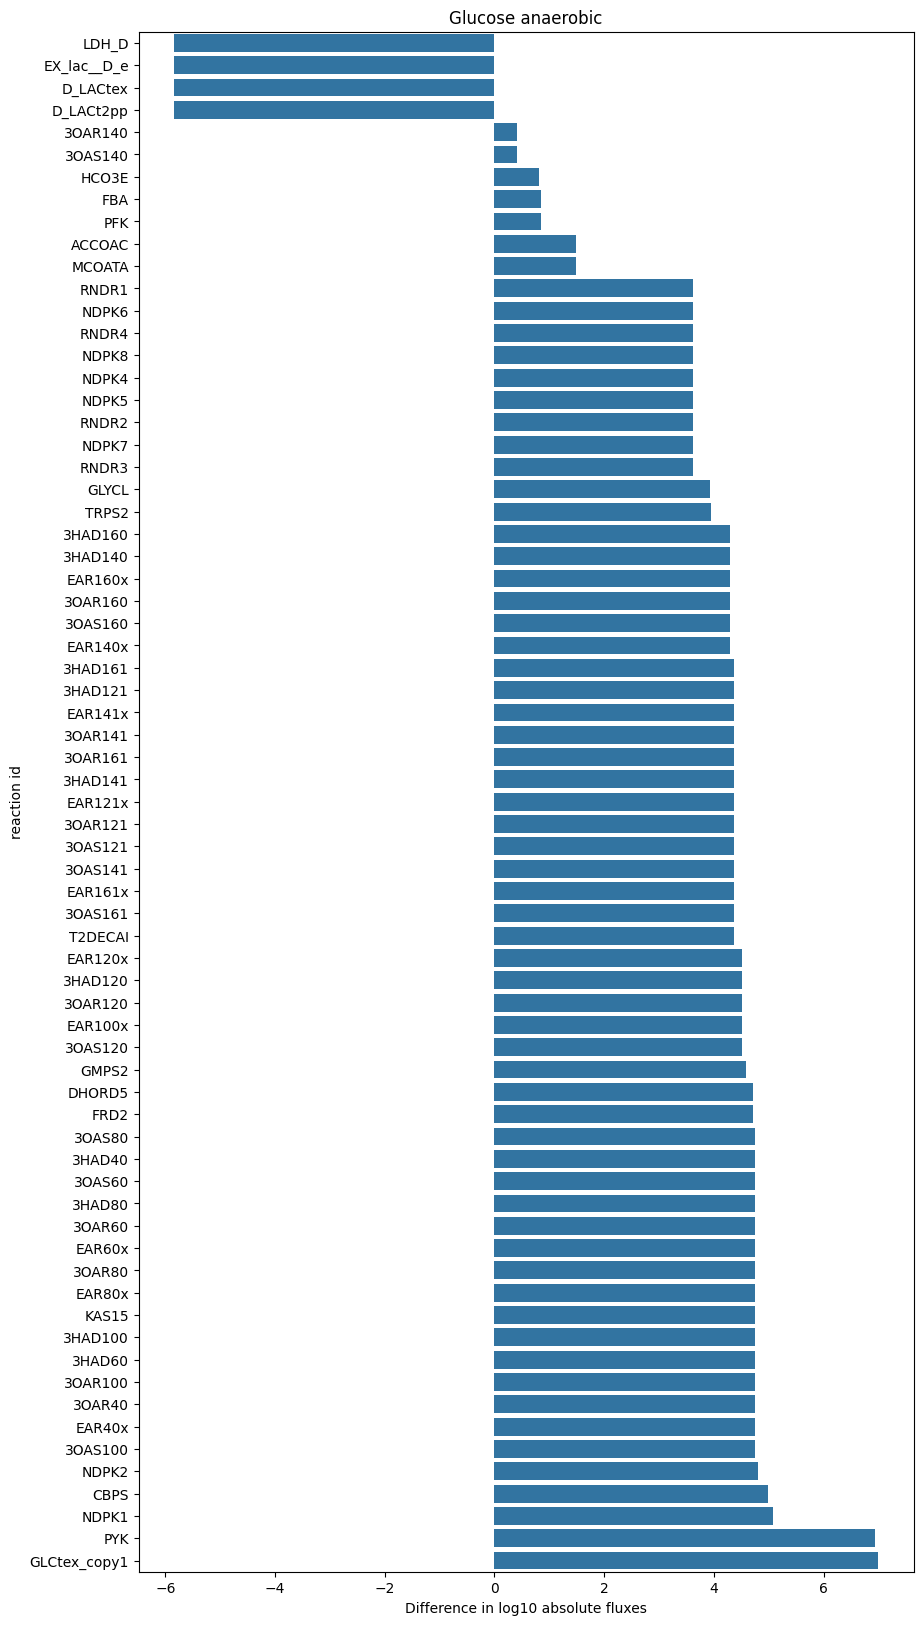

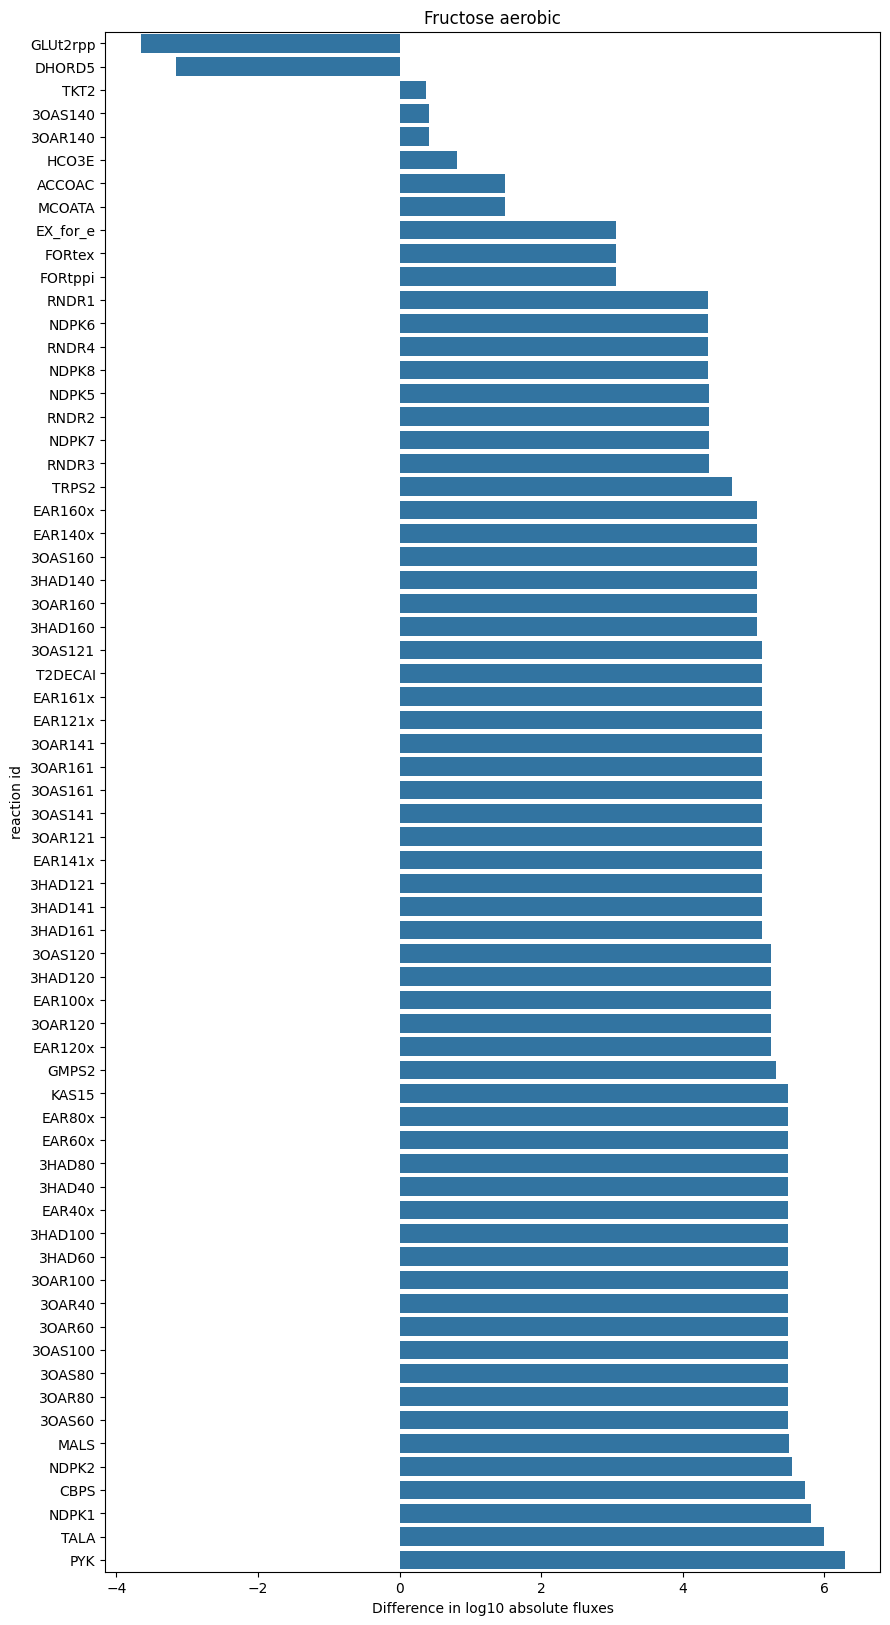

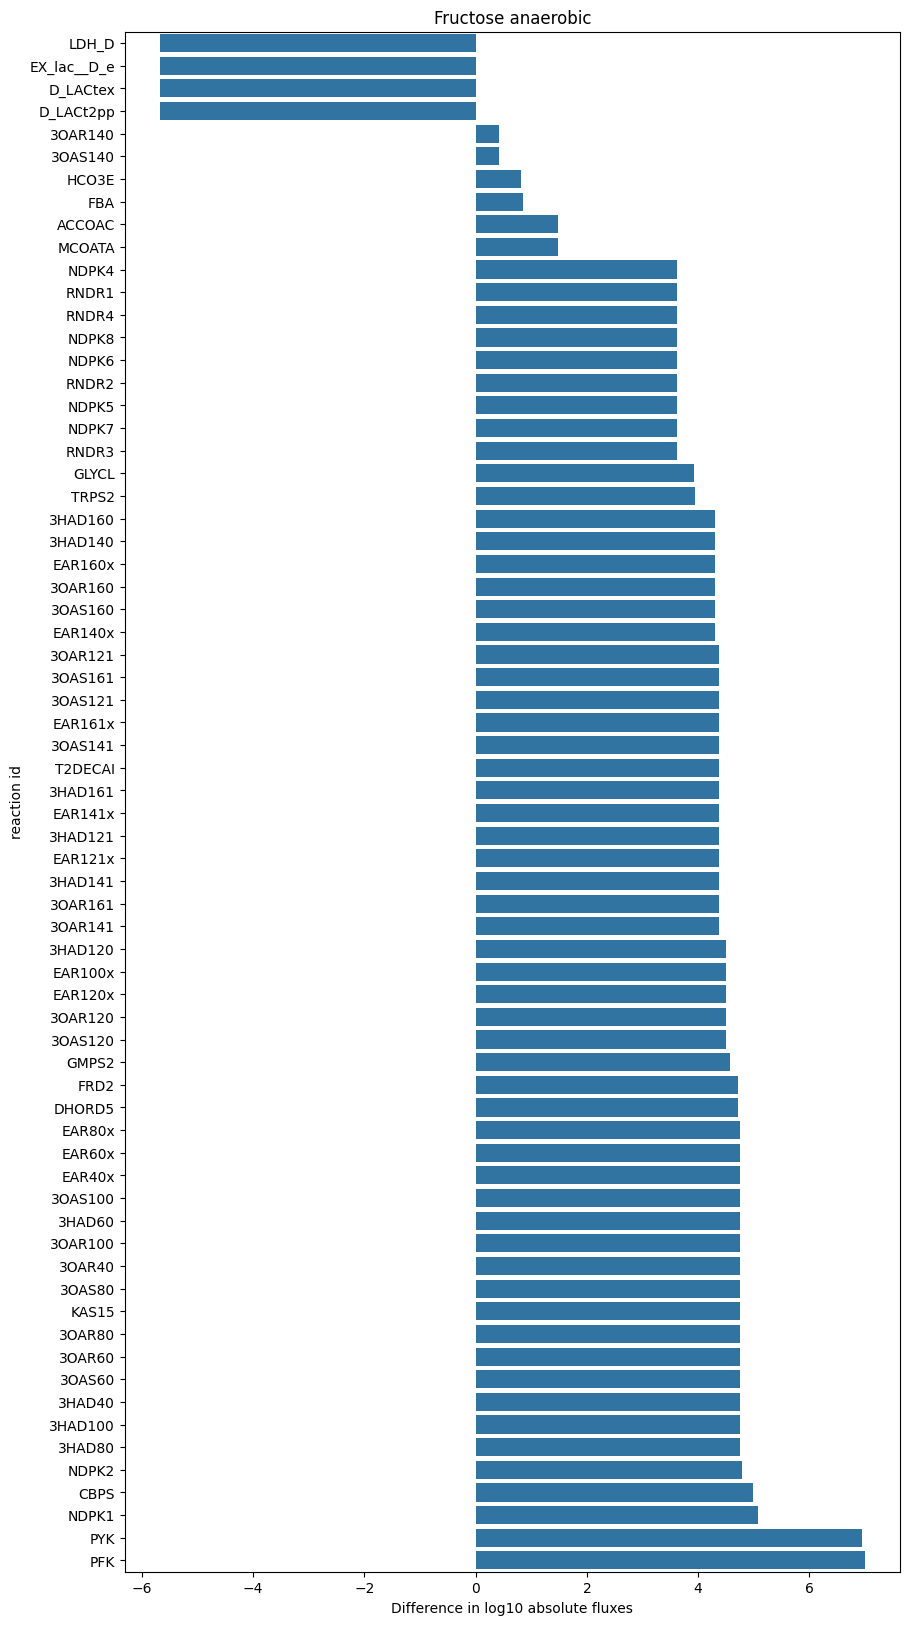

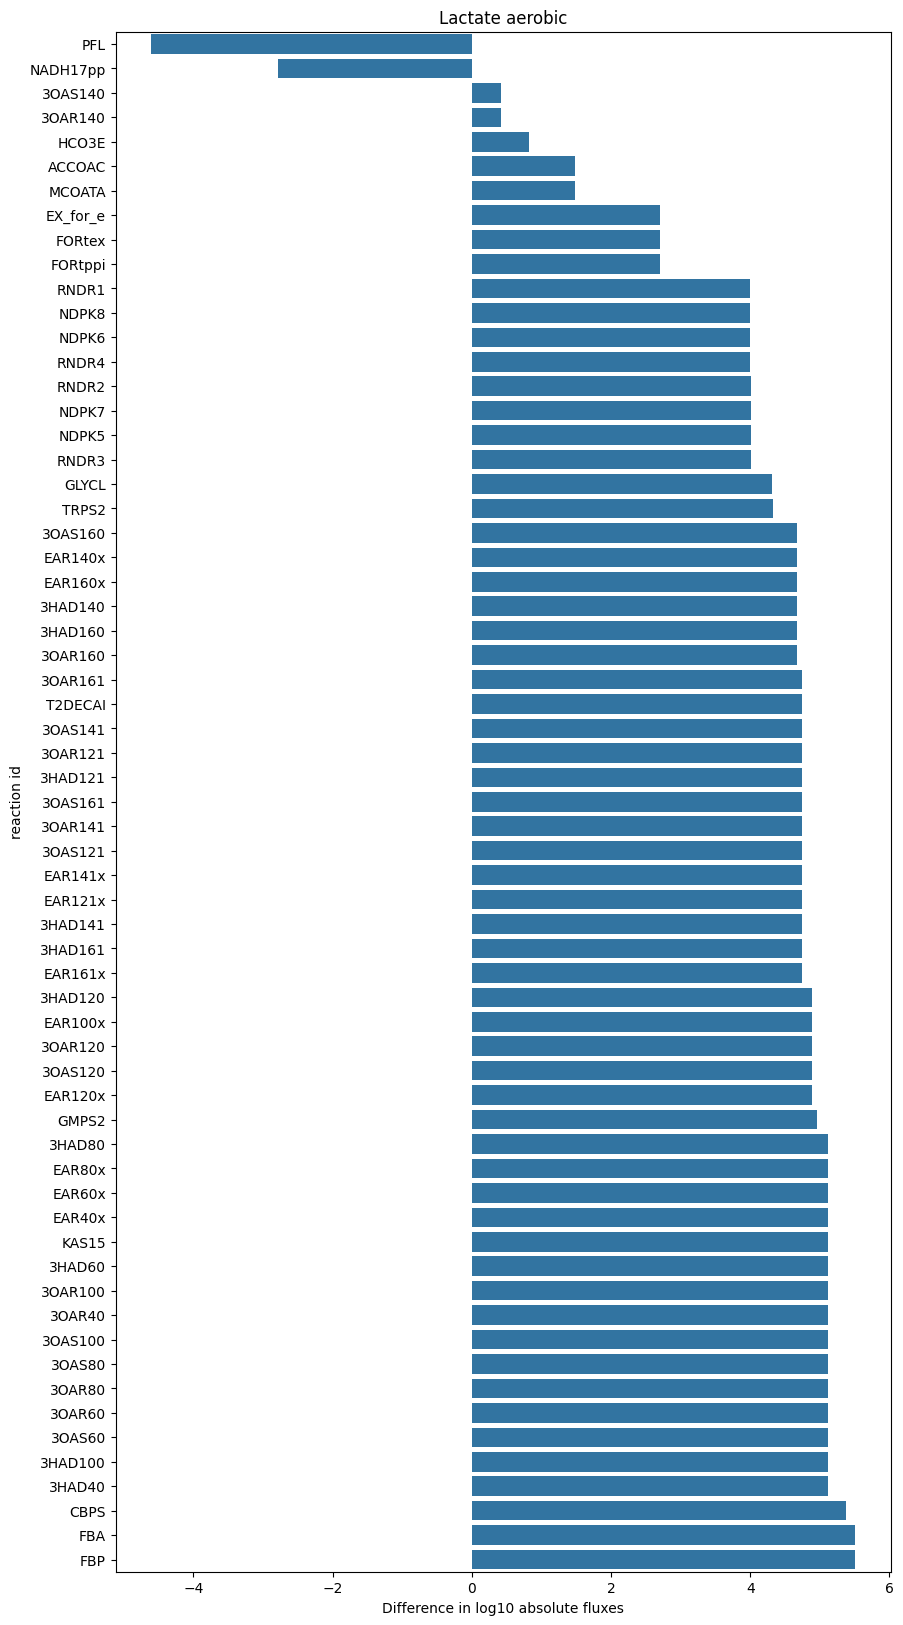

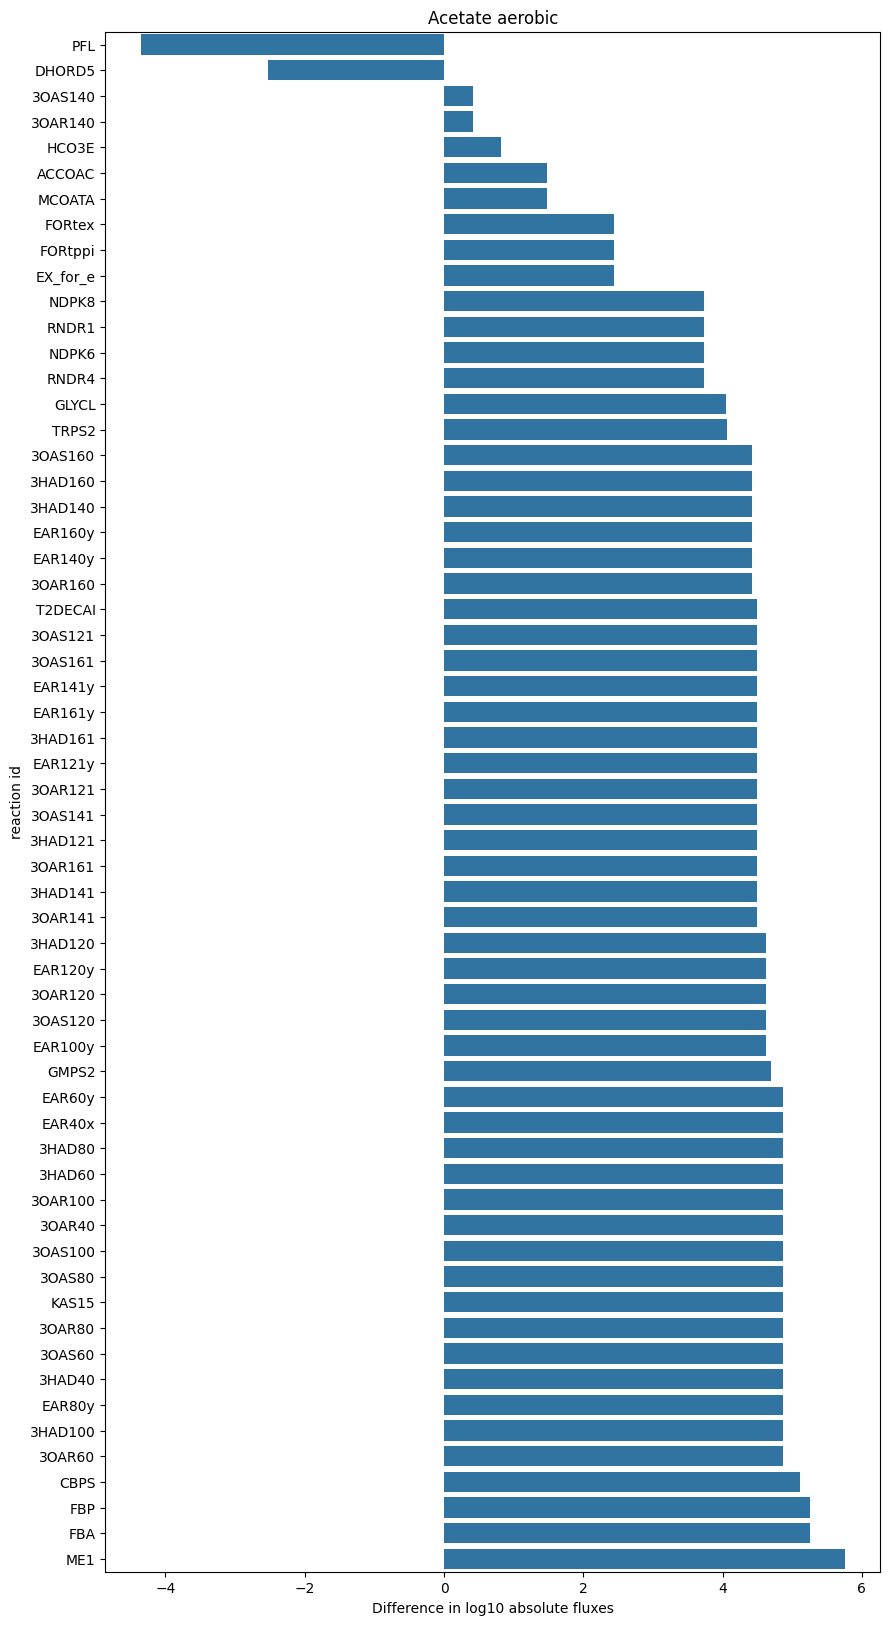

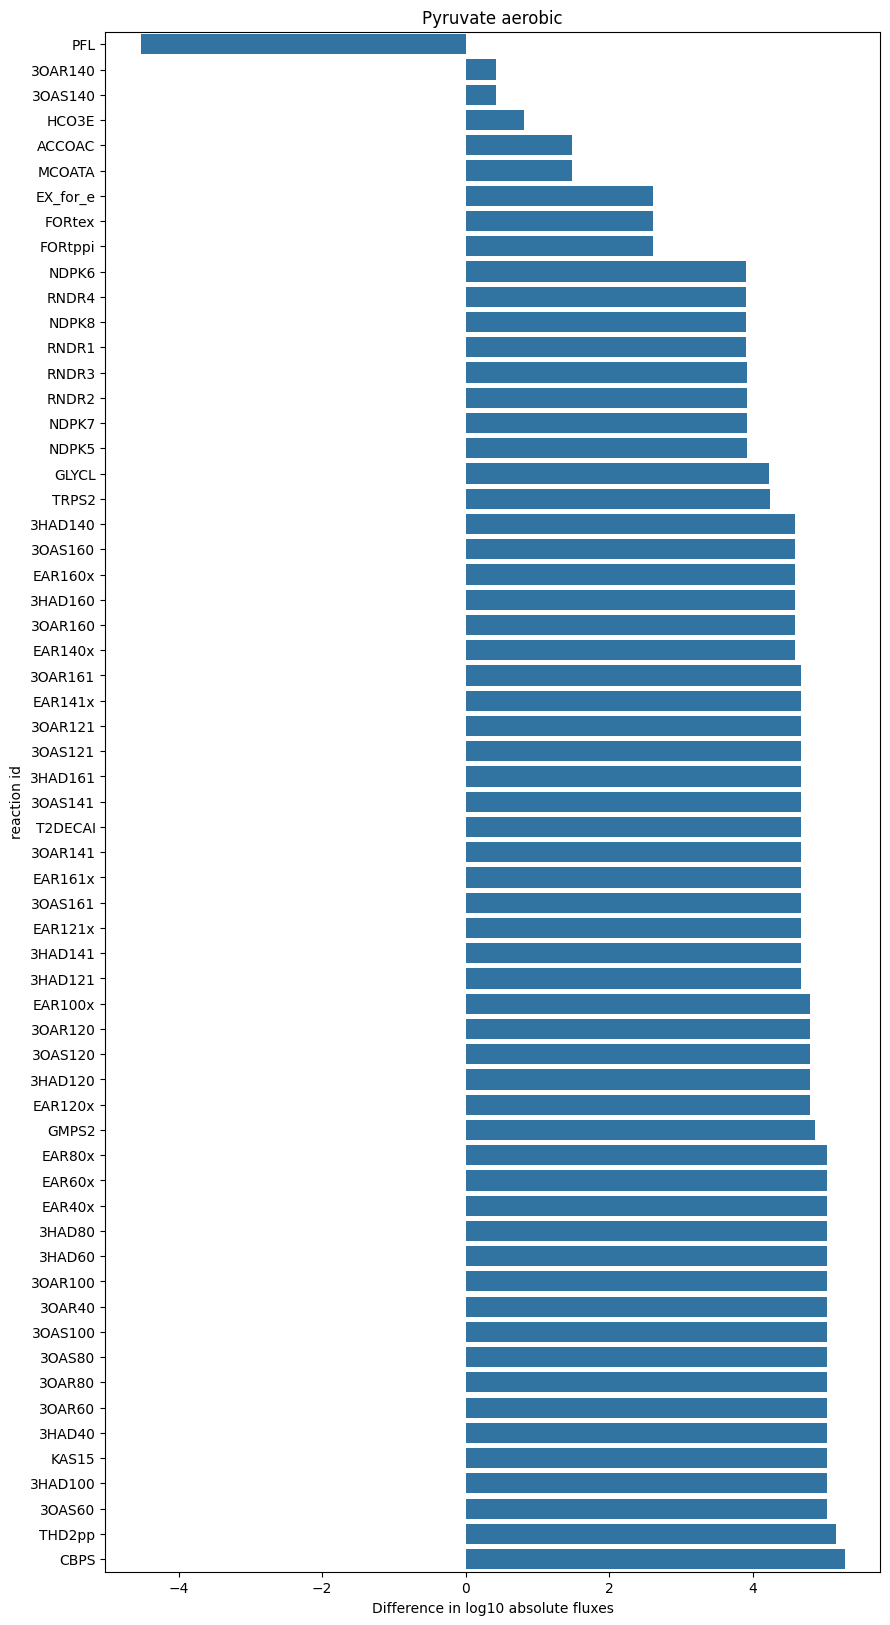

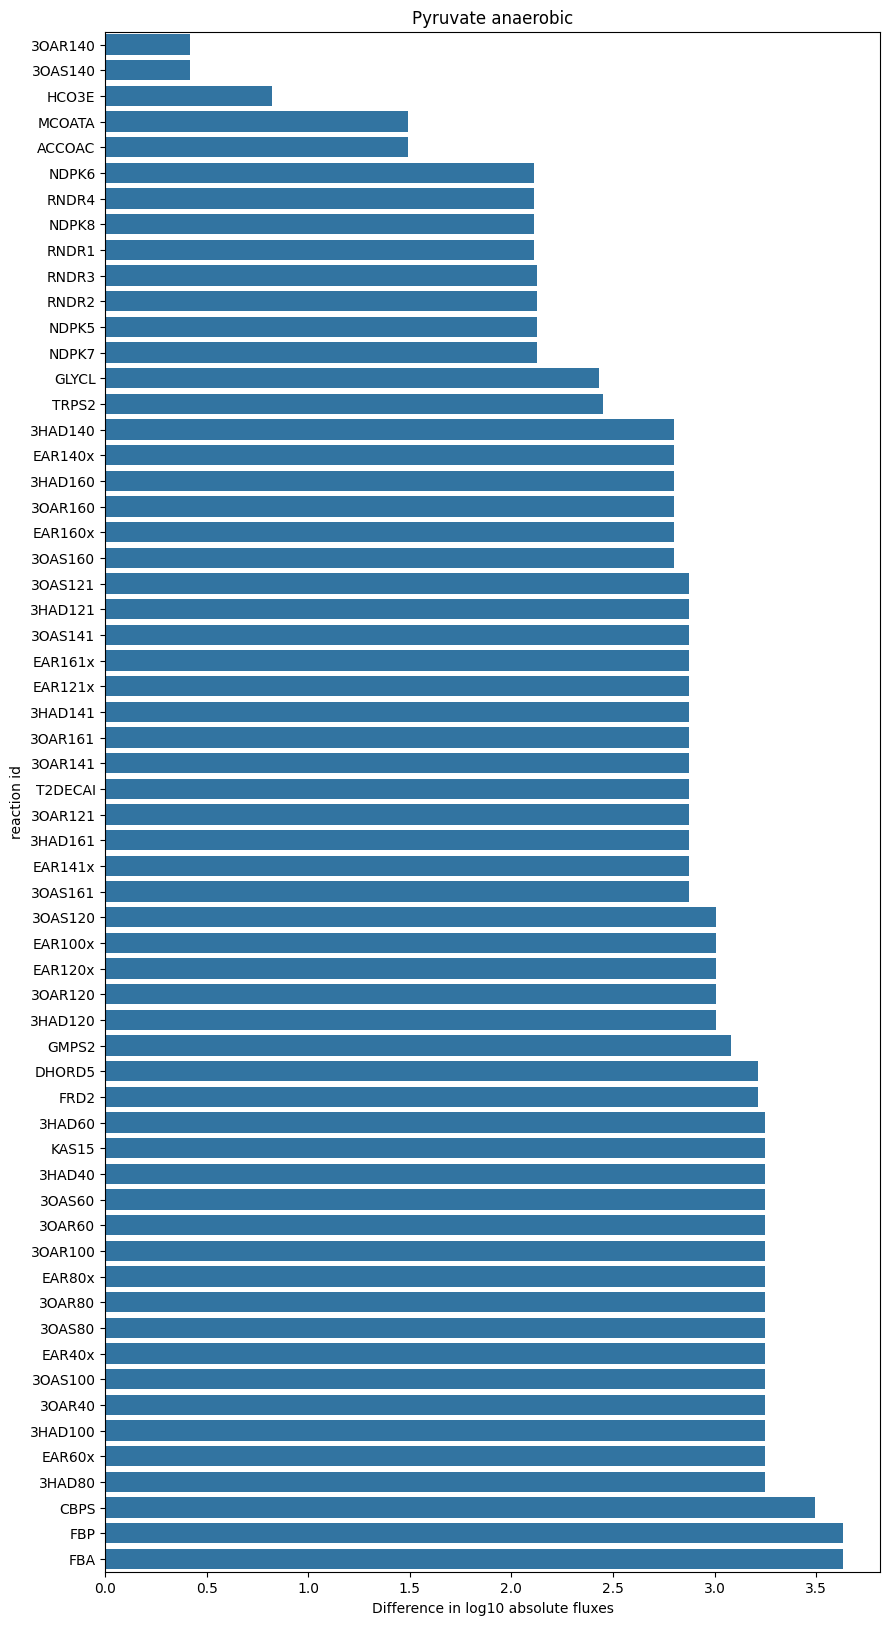

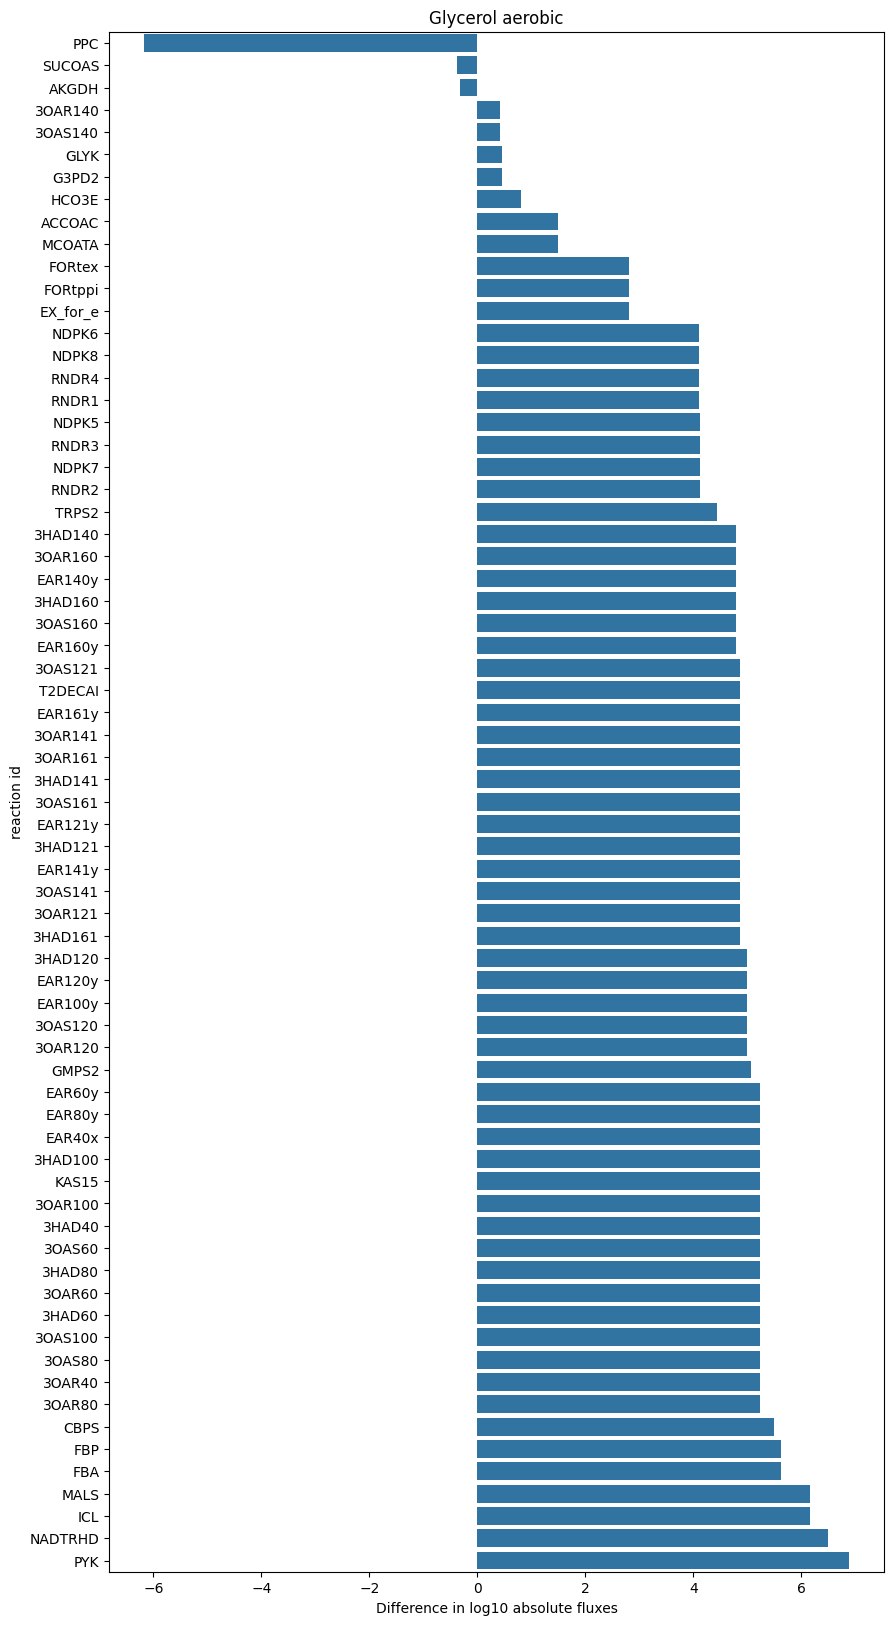

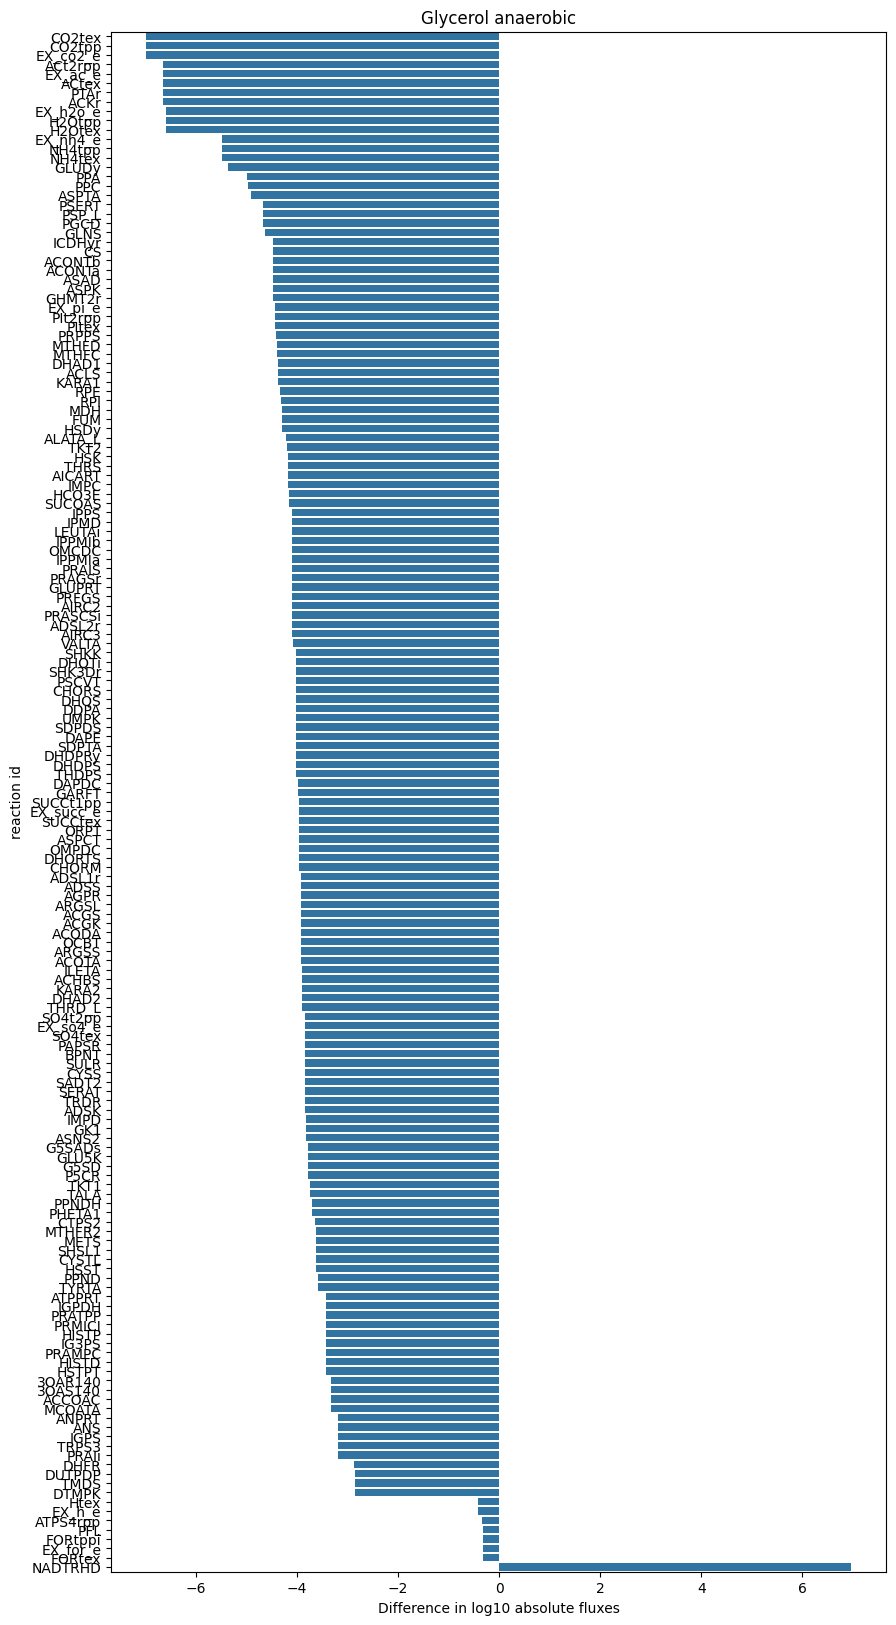

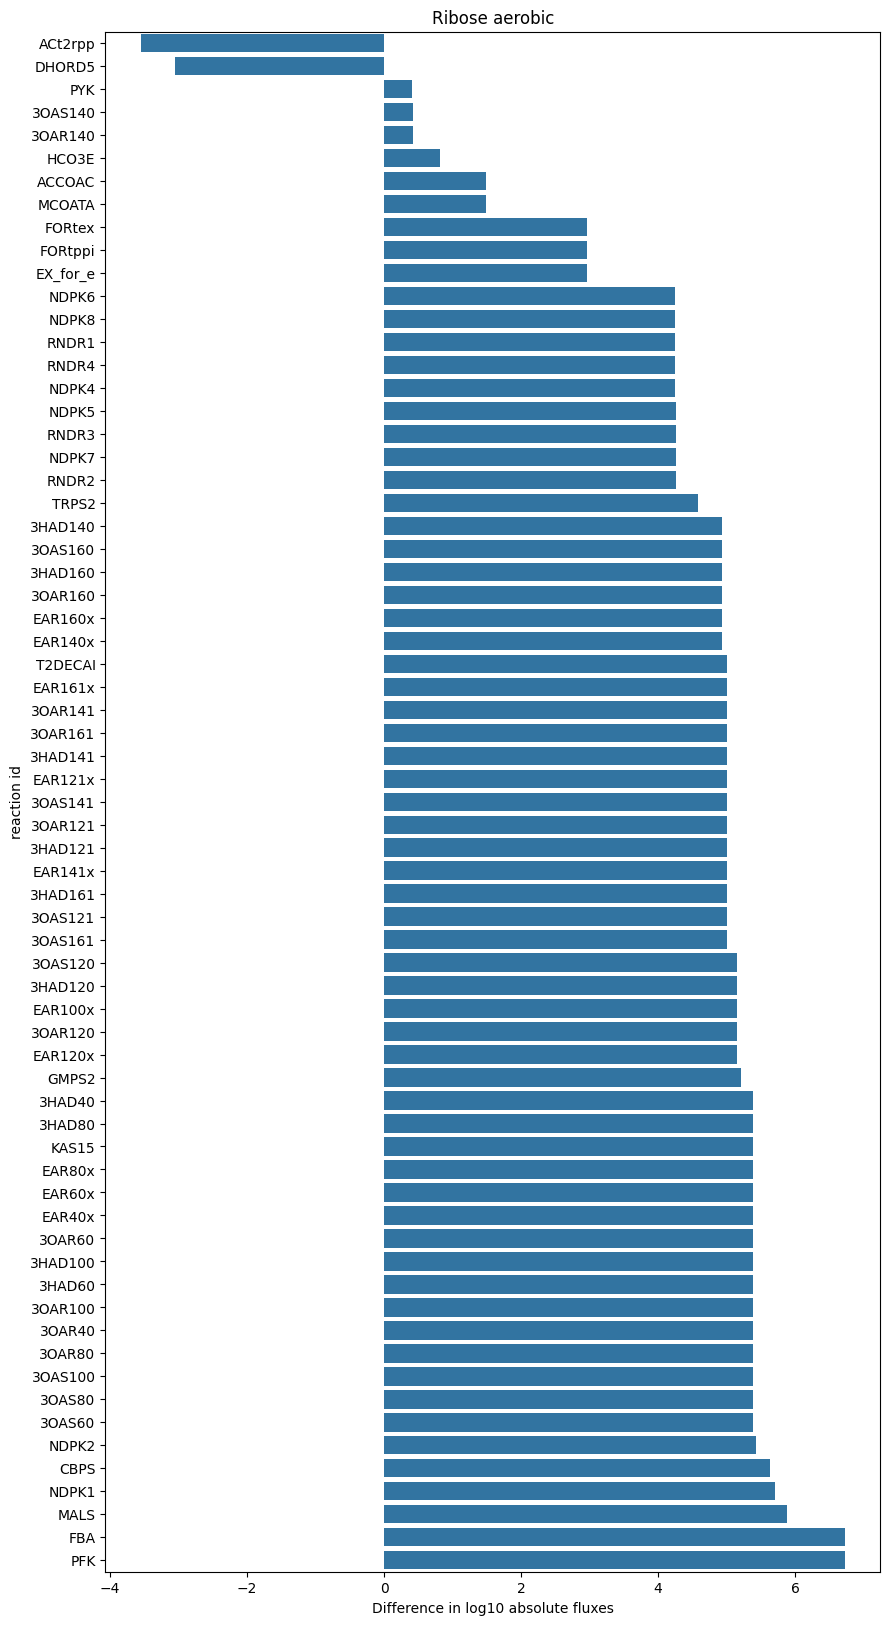

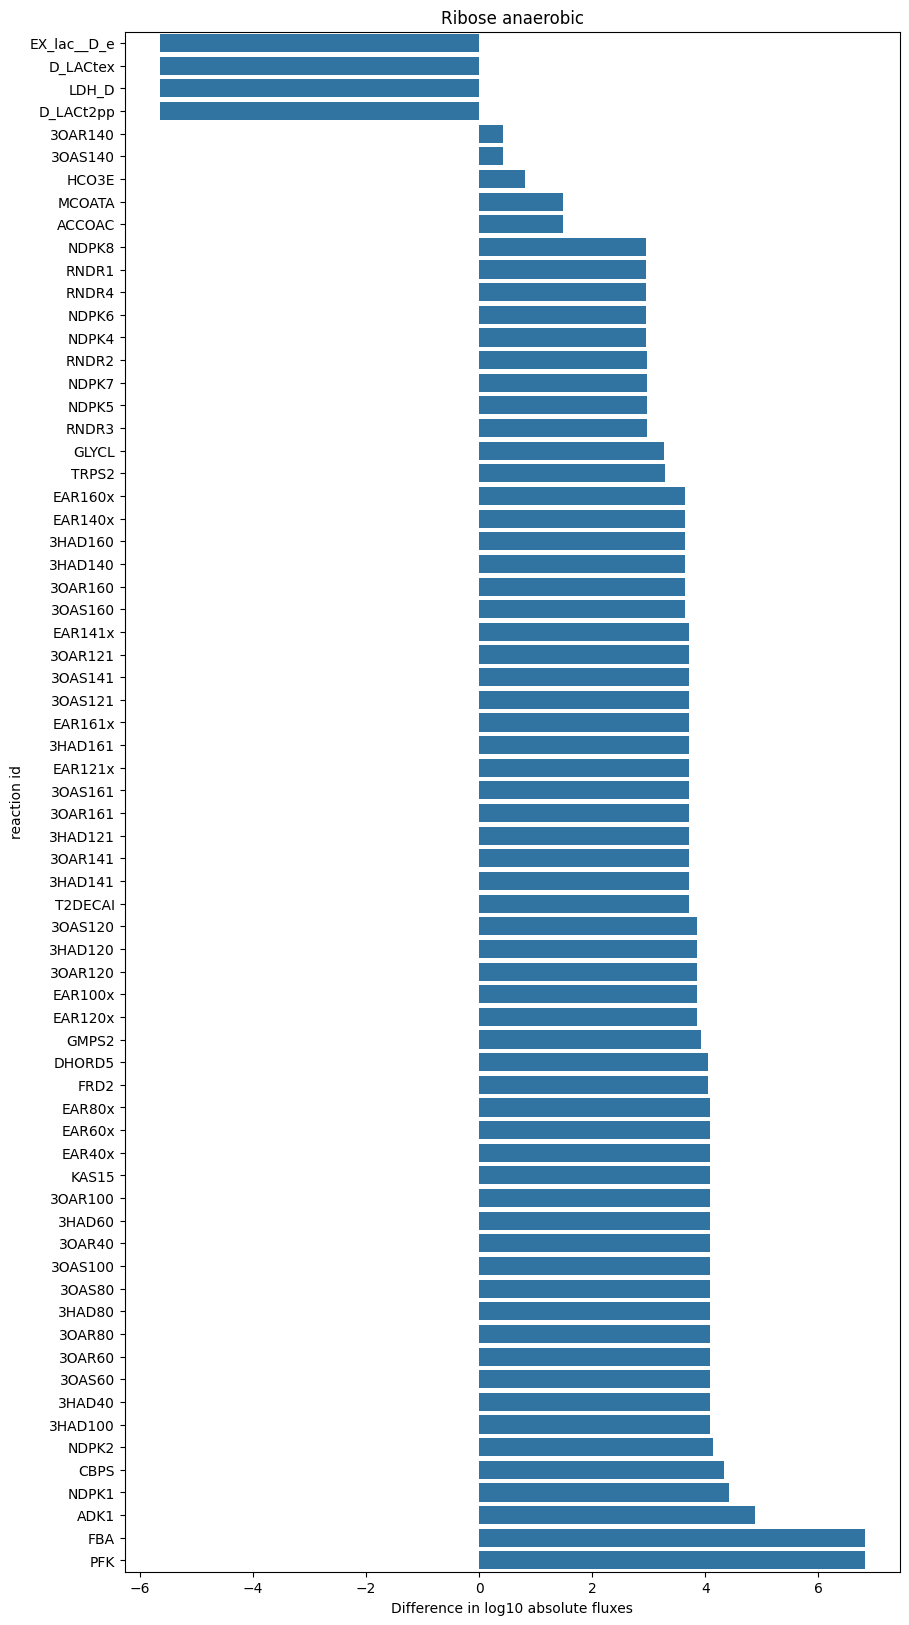

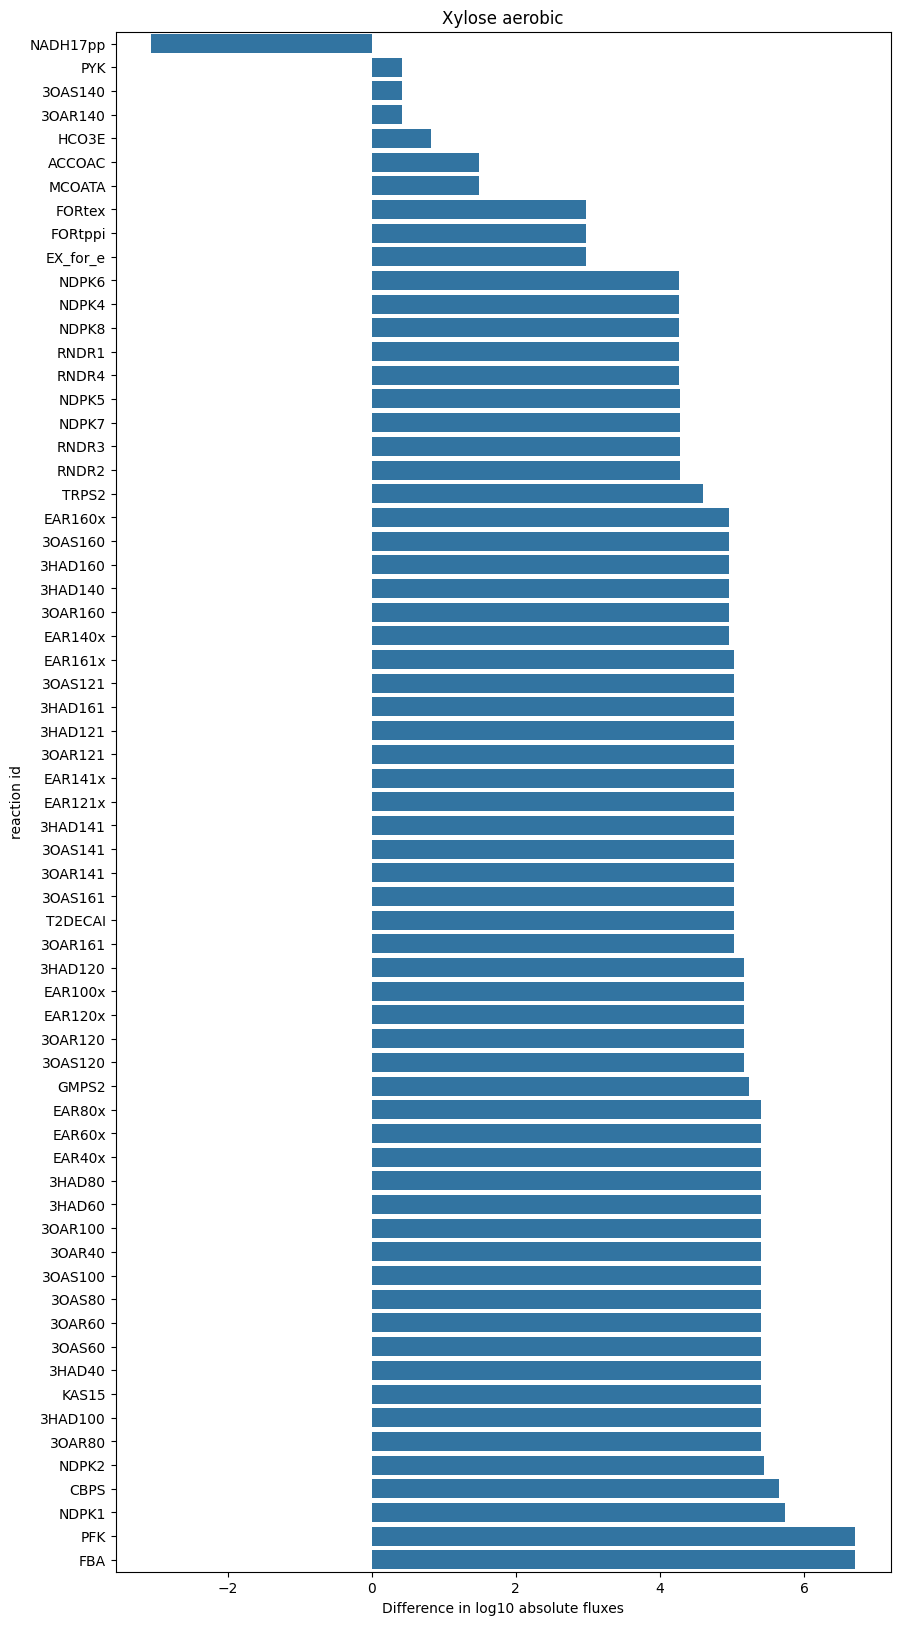

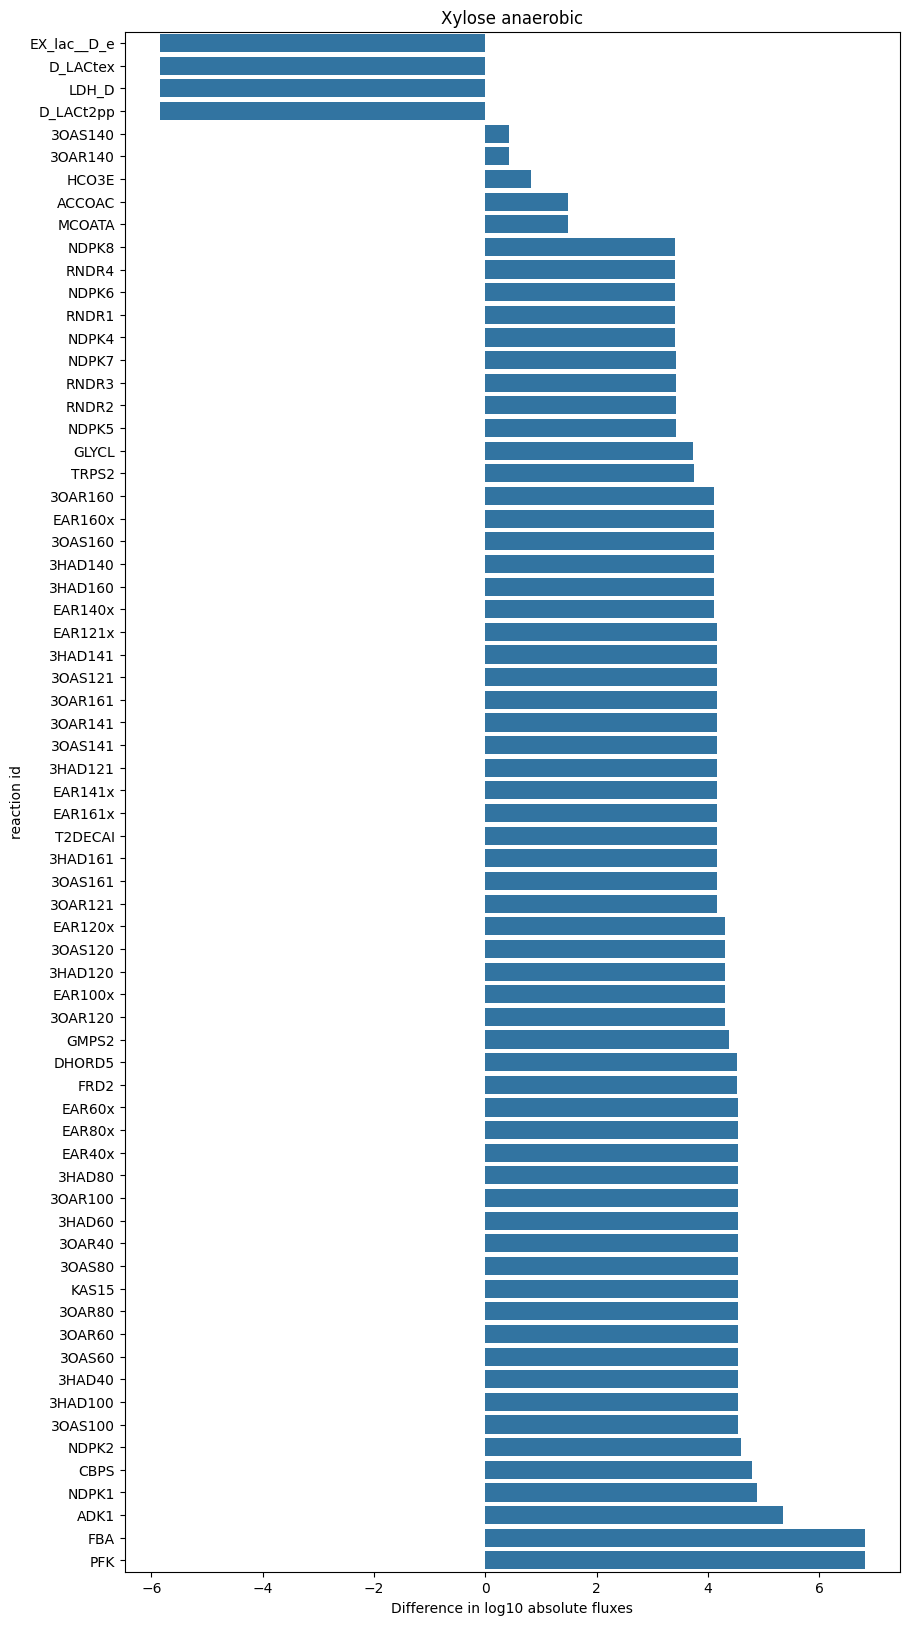

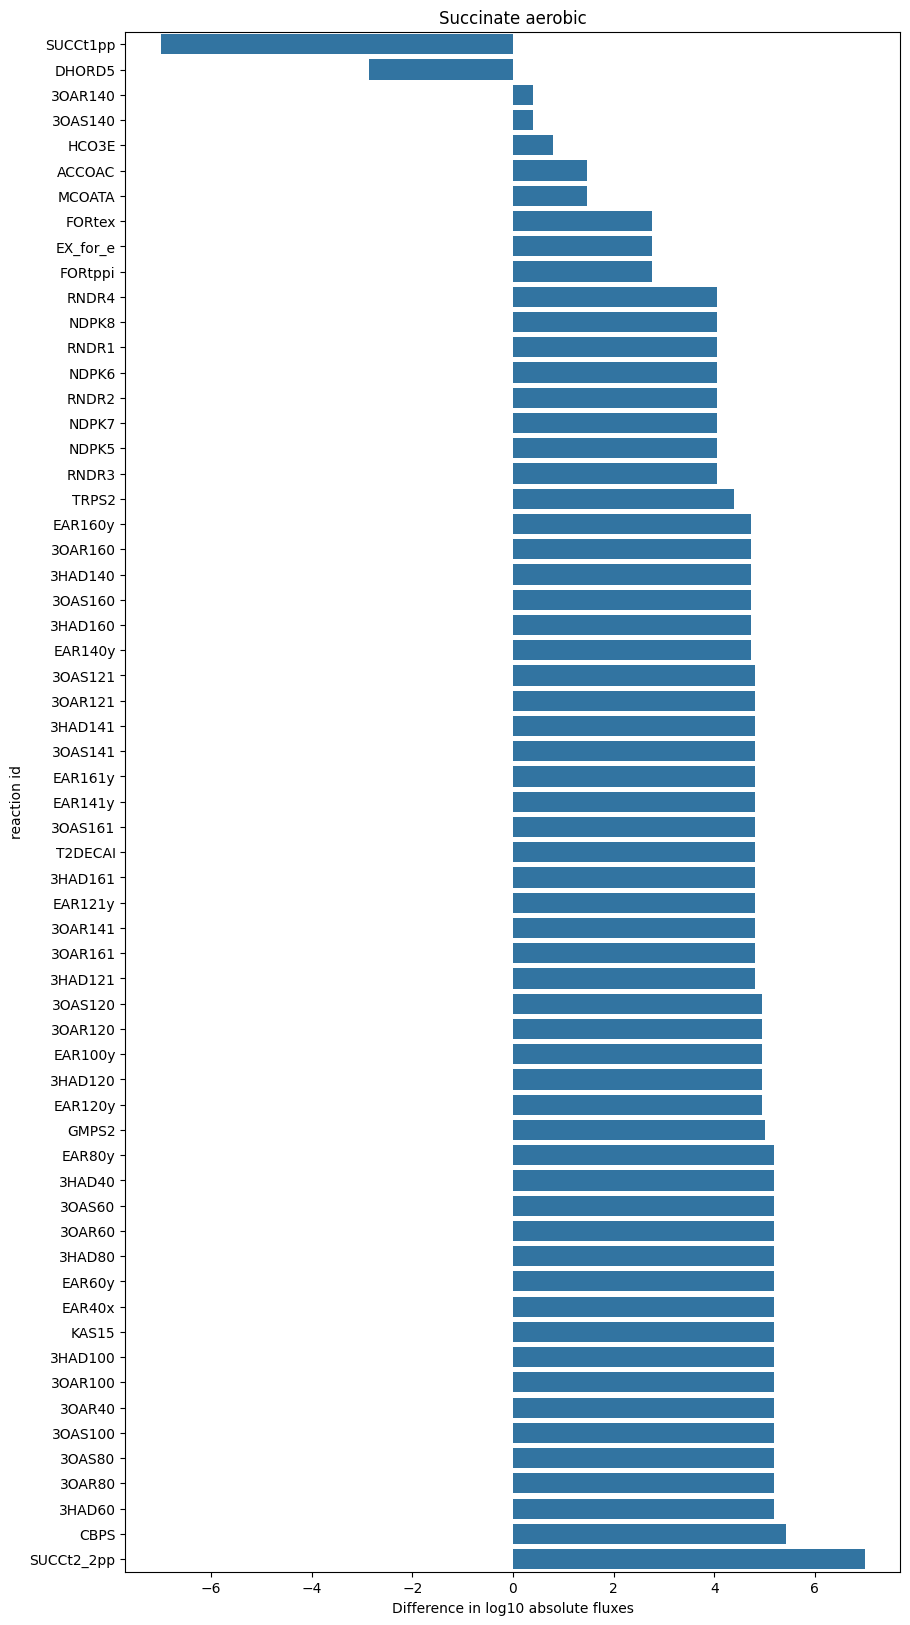

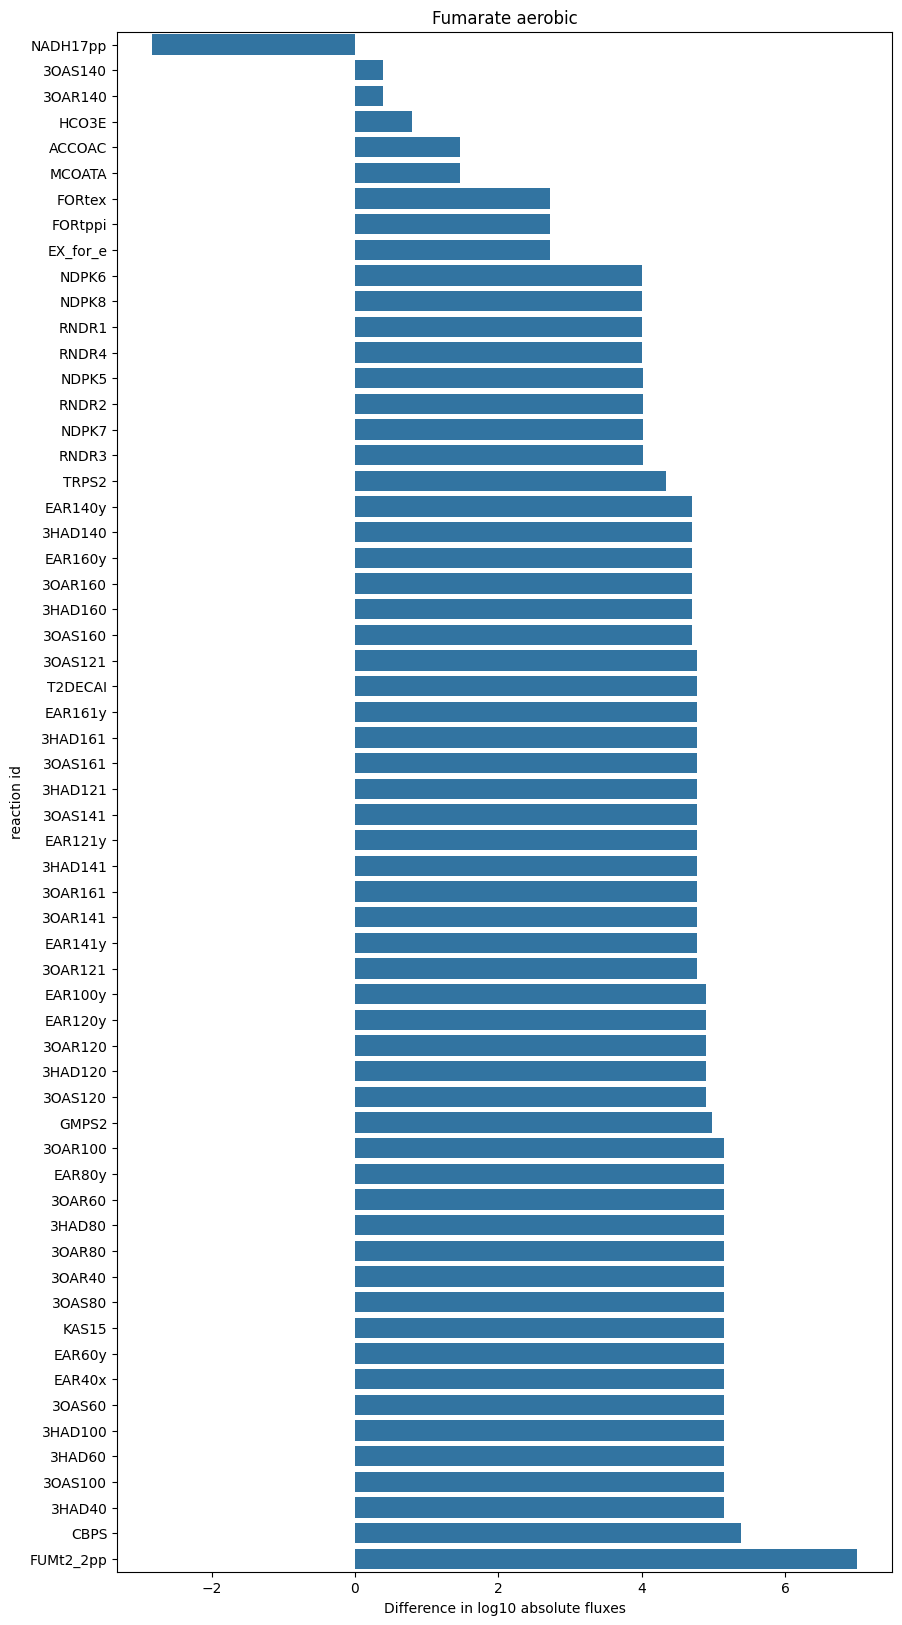

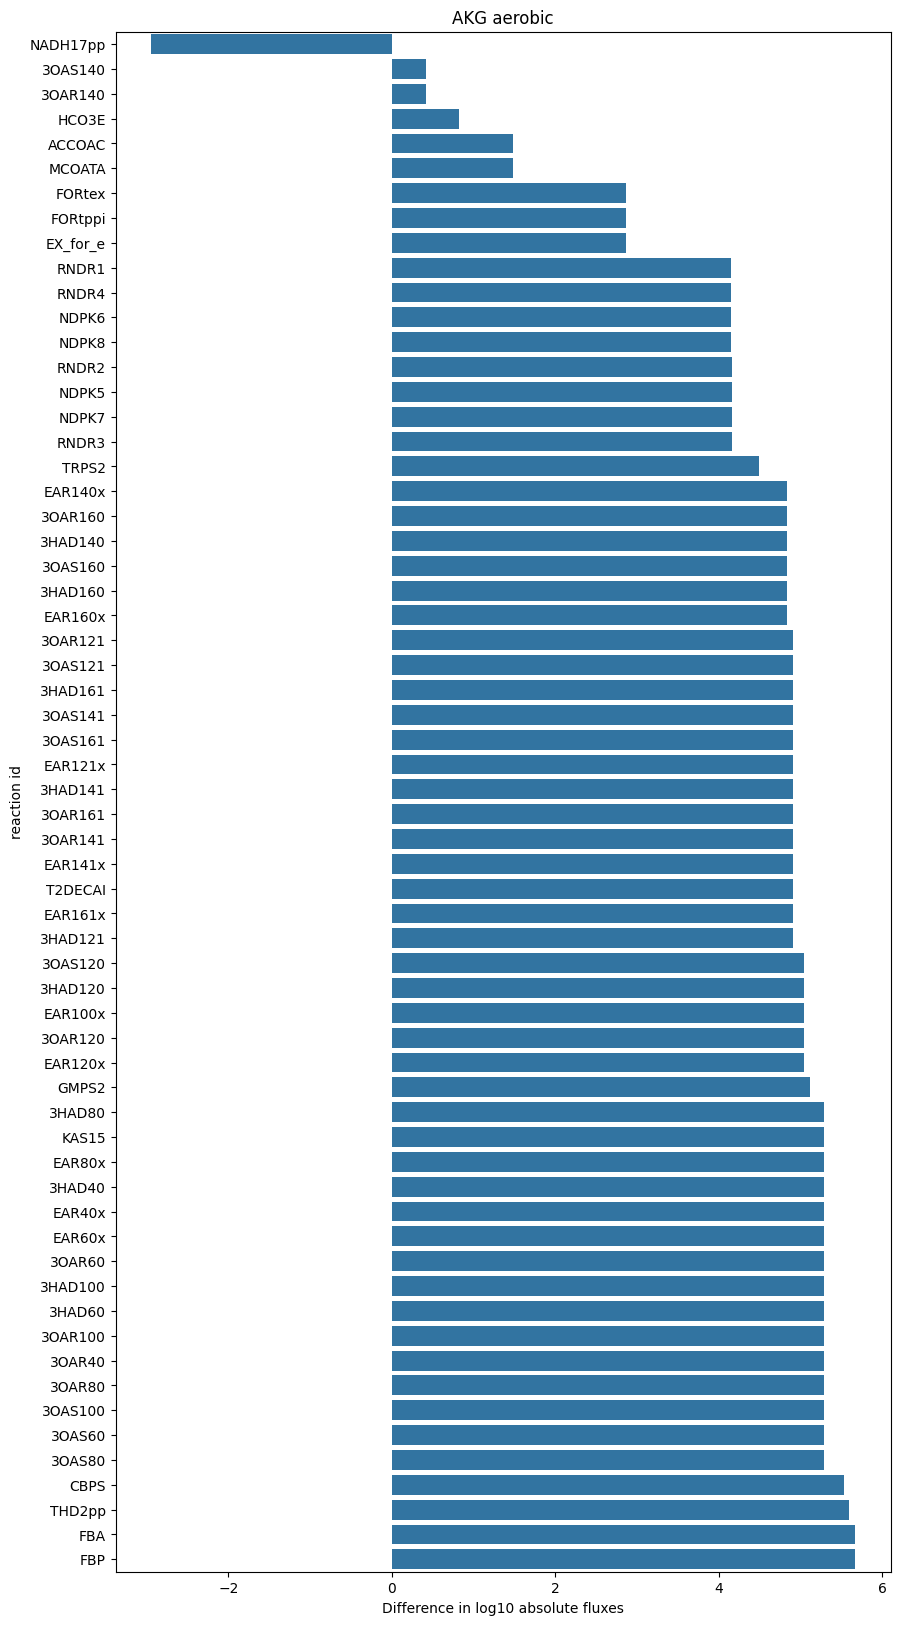

In [13]:
eps=1e-6 #small number to replace zeros in the fluxes
threshold_diff=0.3 #threshold for the difference in log10 scale between fluxes used to pick which reactions to include in the plots
for cs in carbon_sources:
    for condition in conditions:
        if results[cs][condition] is not None:
            cur_data=results[cs][condition]
            #convert zeros into a small eps
            cur_data[cur_data==0.0]=eps
            #compute pairwise difference in log10 scale between fluxes
            cur_data['diff_of_log10']=np.log10(np.abs(cur_data['iCH360'].values))-np.log10(np.abs(cur_data['iML1515'].values))
            #turn index into column
            cur_data=cur_data.reset_index().rename({'index':'reaction_id'},axis=1)
            #reorder
            cur_data=cur_data.sort_values(by='diff_of_log10')
            fig,ax=plt.subplots(figsize=(10,20))
            sns.barplot(cur_data.query("diff_of_log10 >@threshold_diff or diff_of_log10 <-@threshold_diff"),y='reaction_id',x='diff_of_log10',ax=ax)
            ax.set_ylabel('reaction id')
            ax.set_xlabel('Difference in log10 absolute fluxes')
            ax.set_title(f'{carbon_source_id_name_map[cs]} {condition}')
            fig.savefig(f'out/{carbon_source_id_name_map[cs]}_{condition}.pdf')

<Axes: xlabel='diff_of_log10', ylabel='reaction_id'>

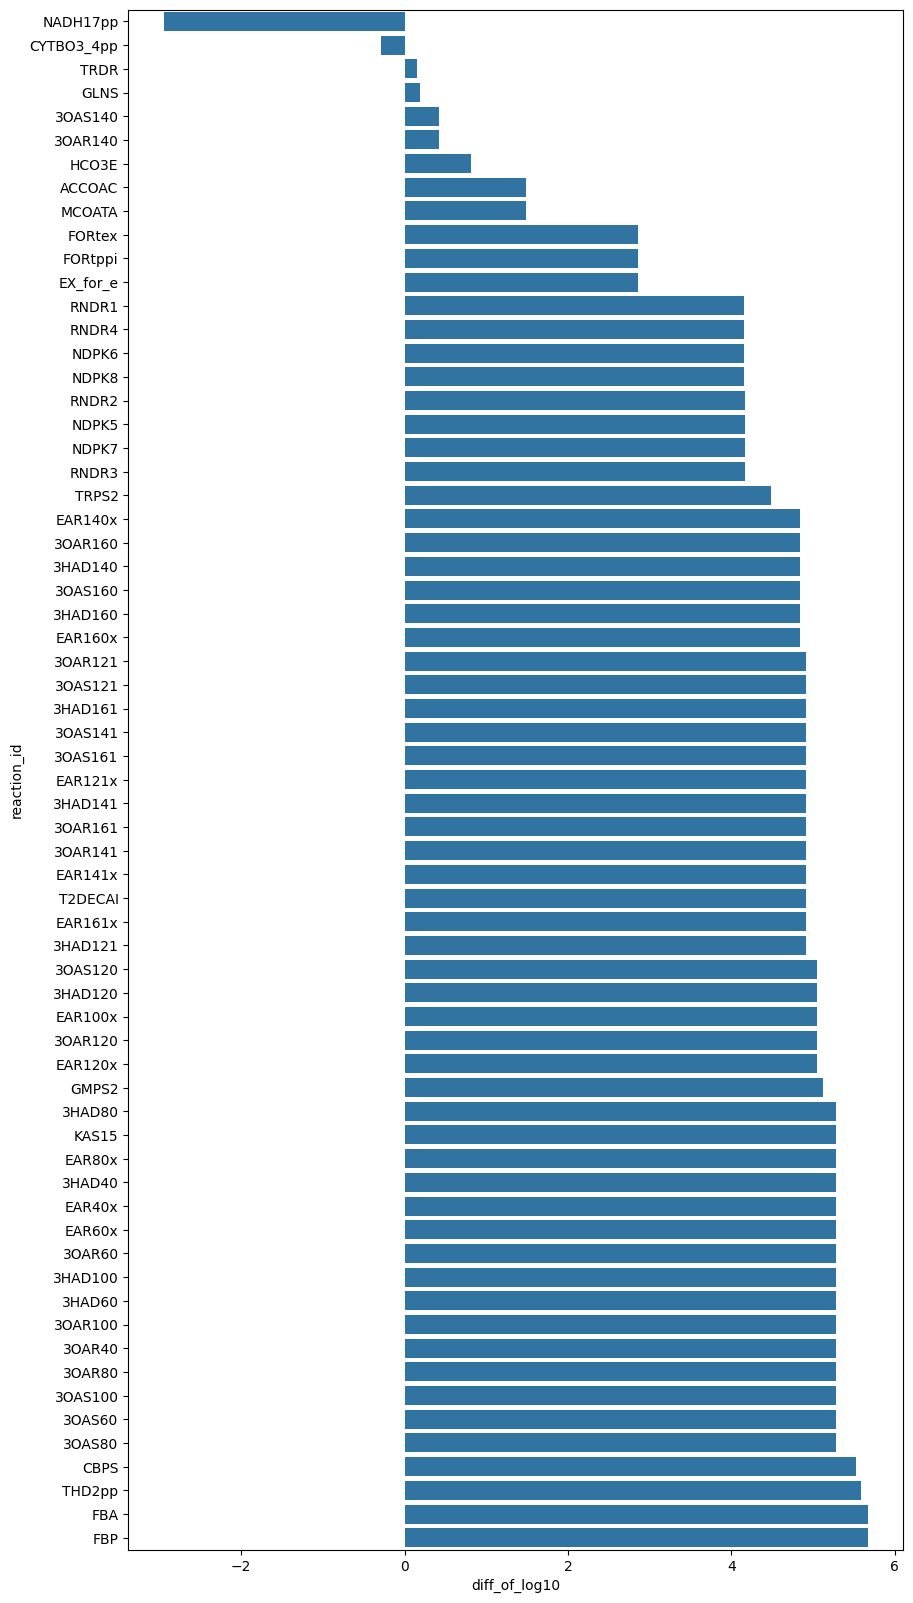

In [11]:
fig,ax=plt.subplots(figsize=(10,20))
sns.barplot(cur_data.query("diff_of_log10 >0.1 or diff_of_log10 <-0.1"),y='reaction_id',x='diff_of_log10',ax=ax)